深度学习第一次实验作业——情感分类

1、数据处理

In [2]:
import torch
print("是否可用：", torch.cuda.is_available())        # 查看GPU是否可用
print("GPU数量：", torch.cuda.device_count())        # 查看GPU数量
print("torch方法查看CUDA版本：", torch.version.cuda)  # torch方法查看CUDA版本
print("GPU索引号：", torch.cuda.current_device())    # 查看GPU索引号
print("GPU名称：", torch.cuda.get_device_name(0))    # 根据索引号得到GPU名称

是否可用： True
GPU数量： 1
torch方法查看CUDA版本： 11.7
GPU索引号： 0
GPU名称： NVIDIA GeForce RTX 4060 Laptop GPU


In [31]:
import os
import shutil
# 将数据的训练数据和测试数据分割，分别储存到两个文件中
train_file = open('testImages_artphoto_train.txt', 'r')
train_list = train_file.read().splitlines()
test_file = open('testImages_artphoto_test.txt', 'r')
test_list = test_file.read().splitlines()
file_name_list = os.listdir('./testImages_artphoto')
for name in file_name_list:
    name.strip()
    if name in train_list:
        shutil.copy('./testImages_artphoto/'+name, './train')
    elif name in test_list:
        shutil.copy('./testImages_artphoto/'+name, './test')
train_file.close()
test_file.close()


In [2]:
import torch
import os
import glob
from PIL import Image
from torch.utils.data import Dataset

# 创建data_set类
class data_set(Dataset):
    def __init__(self, folder, transform=None, train=True):
        self.folder = folder
        self.transform = transform
        self.train = train
        img_list = []
        img_list.extend(glob.glob(os.path.join(self.folder,'*.jpg')))
        self.img_list = img_list
    def __getitem__(self, index):
        img_path = self.img_list[index]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
    
        if 'amusement' in img_path:
            label = torch.tensor([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
            file_name = 'amusement'
        elif 'anger' in img_path:
            label = torch.tensor([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) 
            file_name = 'anger'
        elif 'awe' in img_path:
            label = torch.tensor([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
            file_name = 'awe'
        elif 'content' in img_path:
            label = torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
            file_name = 'content'
        elif 'disgust' in img_path:
            label = torch.tensor([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
            file_name = 'disgust'
        elif 'excitement' in img_path:
            label = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0])
            file_name = 'excitement'
        elif 'fear' in img_path:
            label = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0])
            file_name = 'fear'
        elif 'sad' in img_path:
            label = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
            file_name = 'sad'
            
        return img, label, file_name

    def __len__(self):
        return len(self.img_list)


In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader

# 将数据用dataloader封装
data_transform = transforms.Compose([
    transforms.Resize([450, 450]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = data_set("./train", data_transform, train=True)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, drop_last=True)
test_data = data_set("./test", data_transform, train=False)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True, drop_last=True)

2、模型建立

In [4]:
import torch
import torch.nn as nn

# 建立神经网络模型
class ResBlock(nn.Module):
    
    def __init__(self, in_channel, out_channel):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + res    
        x = self.relu2(x)
        return x


class ResBlockDown(nn.Module):
    
    def __init__(self, in_channel, out_channel):
        super(ResBlockDown, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, 2, 1, bias=False)    
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu2 = nn.ReLU()
        self.pool = nn.Conv2d(in_channel, out_channel, 1, 2, 0, bias=False)
        
    def forward(self, x):
        res = x
        res = self.pool(res)    
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + res
        x = self.relu2(x)
        return x


class ResNet34(nn.Module):
    
    def __init__(self):
        super(ResNet34, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(3, 2, 1)
        self.conv2 = nn.Sequential(
            ResBlockDown(64, 64),
            ResBlock(64, 64),
            ResBlock(64, 64),
        )
        self.conv3 = nn.Sequential(
            ResBlockDown(64, 128),
            ResBlock(128, 128),
            ResBlock(128, 128),
            ResBlock(128, 128),
        )
        self.conv4 = nn.Sequential(
            ResBlockDown(128, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
        )
        self.conv5 = nn.Sequential(
            ResBlockDown(256, 512),
            ResBlock(512, 512),
            ResBlock(512, 512),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 8)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

3、模型训练

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义超参数
epoches = 40
lr = 0.001

# 定义损失函数和随机梯度下降优化器
model = ResNet34()
model.weight_init()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 训练模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.train()
model.to(device)

for epoch in range(epoches):
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets, file_name) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), targets.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = outputs.to(device).max(1)
        _, true_label = targets.to(device).max(1)
        total += targets.to(device).size(0)
        correct += predicted.to(device).eq(true_label.to(device)).sum().item()

        if batch_idx % 20 == 0 or batch_idx == (len(train_loader)-1) :
            print(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


0 56 Loss: 2.060 | Acc: 10.000% (1/10)
20 56 Loss: 2.949 | Acc: 14.286% (30/210)
40 56 Loss: 2.646 | Acc: 17.317% (71/410)
55 56 Loss: 2.501 | Acc: 17.857% (100/560)
0 56 Loss: 1.739 | Acc: 50.000% (5/10)
20 56 Loss: 2.069 | Acc: 22.381% (47/210)
40 56 Loss: 2.084 | Acc: 22.195% (91/410)
55 56 Loss: 2.108 | Acc: 20.357% (114/560)
0 56 Loss: 2.194 | Acc: 10.000% (1/10)
20 56 Loss: 2.020 | Acc: 21.905% (46/210)
40 56 Loss: 2.046 | Acc: 21.220% (87/410)
55 56 Loss: 2.053 | Acc: 21.071% (118/560)
0 56 Loss: 1.757 | Acc: 40.000% (4/10)
20 56 Loss: 2.053 | Acc: 22.857% (48/210)
40 56 Loss: 2.065 | Acc: 21.951% (90/410)
55 56 Loss: 2.041 | Acc: 23.214% (130/560)
0 56 Loss: 2.075 | Acc: 10.000% (1/10)
20 56 Loss: 2.053 | Acc: 21.905% (46/210)
40 56 Loss: 2.031 | Acc: 23.171% (95/410)
55 56 Loss: 2.025 | Acc: 22.857% (128/560)
0 56 Loss: 1.937 | Acc: 10.000% (1/10)
20 56 Loss: 1.986 | Acc: 23.333% (49/210)
40 56 Loss: 1.989 | Acc: 23.659% (97/410)
55 56 Loss: 2.017 | Acc: 22.679% (127/560)
0 56

In [1]:
# 模型的保存
torch.save(model, 'model_ResNet34.pth')

NameError: name 'torch' is not defined

4、模型测试

In [5]:
import torch
import torch.nn as nn

# 测试模型
model_path = "./model_ResNet34.pth"
model = ResNet34()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
weights = torch.load(model_path).state_dict()
model.load_state_dict(weights)
model.eval()  

test_loss = 0
correct = 0
total = 0
with torch.no_grad(): 
    for batch_idx, (inputs, targets, file_name) in enumerate(test_loader):
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        _, true_label = targets.max(1)
        total += targets.size(0)
        correct += predicted.eq(true_label.to(device)).sum().item()
        
        print(batch_idx, len(test_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


KeyboardInterrupt: 

5、定性结果展示

Predict sentiment is : ['content', 'content', 'content', 'content']
Real sentiment is : ['amusement', 'fear', 'sad', 'fear']


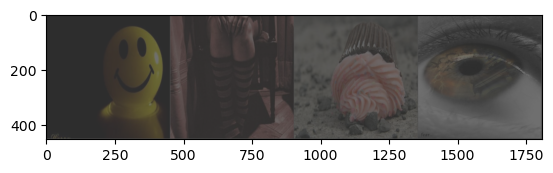

In [48]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

sample_test = DataLoader(dataset = test_data,shuffle=True,batch_size=4)
X_test, Y_test, Z_test = next(iter(sample_test))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inputs = X_test.reshape(-1, 3, 450, 450).to(device)
pred = model(inputs)
_,pred = torch.max(pred, 1)

pred_name = []
for i in pred:
    if i == 0:
        pred_name.append('amusement')
    elif i == 1:
        pred_name.append('anger')
    elif i == 2:
        pred_name.append('awe')
    elif i == 3:
        pred_name.append('content')
    elif i == 4:
        pred_name.append('disgust')
    elif i == 5:
        pred_name.append('excitement')
    elif i == 6:
        pred_name.append('fear')
    elif i == 7:
        pred_name.append('sad')

print("Predict sentiment is :", [i for i in pred_name])
print("Real sentiment is :", [i for i in Z_test])
img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1,2,0)
# std = [0.1307,0.1307,0.1307]
# mean = [0.3081,0.3081,0.3081]
std = (0.1307,)
mean = (0.3081,)
img = img*std+mean
plt.imshow(img)

In [3]:
import torch
import torch.nn
import onnx
 
model = torch.load('best.pt')
model.eval()
 
input_names = ['input']
output_names = ['output']
 
x = torch.randn(1,3,640,640,requires_grad=True)
 
torch.onnx.export(model, x, 'best.onnx', input_names=input_names, output_names=output_names, verbose='True')



ModuleNotFoundError: No module named 'models'